# **Gene Expression Heatplot**
This notebook generates a heat plot representing sex-biased differential gene expression as well as a plot showing the counts of differentially expressed genes per tissue.

## **Running this notebook**:

See the README for setting up prerequisites for the notebook.

# 1. Setup

In [3]:
defaultW <- getOption("warn")  # suppress warnings for this cell
options(warn = -1) 

library(stringr)
library(edgeR)
library(pheatmap)
library(magrittr)
library(dplyr)
library(ggplot2)
library(scales)
library(viridis)
library(scales)

Sys.setenv(TAR = "/bin/tar") # for gzfile

options(warn = defaultW)

## Heatplot representing similarity in the fold-changes between male and female samples
The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

1. Get differential gene expression (DGE) files
2. Use the ``../assets/tissues.tsv`` to limit the tissues to those with at least 50 samples in each sex (``tissues.tsv`` was produced by a Python script)
3. 

In [18]:
filenames <- list.files("../data", pattern="*_DGE.csv", all.files=FALSE, full.names=TRUE)
message("Number of DGE files found with *_DGE.csv pattern: ",length(filenames))

Number of DGE files found with *_DGE.csv pattern: 6



In [21]:
head(filenames)
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))
# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

message("Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)",
        paste(dim(tissue_reduction), collapse=" "))

[1] "../data/adipose_subcutaneous_DGE.csv"    
[2] "../data/adipose_visceral_omentum_DGE.csv"
[3] "../data/adrenal_gland_DGE.csv"           
[4] "../data/artery_aorta_DGE.csv"            
[5] "../data/artery_coronary_DGE.csv"         
[6] "../data/artery_tibial_DGE.csv"


 0  1 
11 39 

Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)39 5



In [22]:
# preserve the ordered rownames for later assignment to matrix
fullfilename <-filenames[1]
logFC_mat    <- read.csv(fullfilename)
pVal_mat     <- logFC_mat
logFC_mat    <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 
pVal_mat_rownames  <- logFC_mat_rownames
pVal_mat     <- logFC_mat

In [23]:
head(logFC_mat)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,0.187120063,5.577425,3.72856810,0.0002182802,0.008671240,-1.224138
ENSG00000000005.5,0.417140694,4.004495,3.63725550,0.0003092299,0.010916736,-1.295612
ENSG00000000419.12,-0.002243719,4.685252,-0.09078339,0.9277068987,0.961503738,-7.903498
ENSG00000000457.13,-0.005474788,3.911415,-0.21458951,0.8301889108,0.902548833,-7.756251
ENSG00000000460.16,-0.012659230,2.205476,-0.34517715,0.7301296596,0.837772733,-7.455475
ENSG00000000938.12,0.327508275,5.248948,3.73991142,0.0002091704,0.008417187,-1.133228


In [24]:
# Make a logFC matrix for each of the tissues
# from what files are saved
make_tissue_matrix_ready <- function (file) {
    filename        <- paste('../data',file,sep="/")
    logFC_mat       <- read.csv(filename)
    logFC_mat       <- logFC_mat[order(rownames(logFC_mat)),]
    logFC           <- as.matrix(as.numeric(logFC_mat$logFC),ncol=1)
    rownames(logFC) <- rownames(logFC_mat)
    return(logFC)
}


In [25]:
# Make a adjPVal matrix for each of the tissues
# from what files are saved
make_pval_matrix_ready <- function (file) {
    filename        <- paste('../data',file,sep="/")
    pVal_mat       <- read.csv(filename)
    pVal_mat       <- pVal_mat[order(rownames(pVal_mat)),]
    pVal           <- as.matrix(as.numeric(pVal_mat$adj.P.Val),ncol=1)
    rownames(pVal) <- rownames(pVal_mat)
    return(pVal)
}

In [28]:
matrix_list <- lapply(X=filenames, FUN=make_tissue_matrix_ready)
message("Length of matrix_list", length(matrix_list))

Length of matrix_list6



In [31]:
pVal_matrix_list <- lapply(X=filenames, FUN=make_pval_matrix_ready)
message("Length of pVal_matrix_list: ", length(pVal_matrix_list))

Length of pVal_matrix_list: 6



In [30]:
# rows are the number of samples, columns are the tissues
logFC_mat = as.matrix(lapply(X   = matrix_list, 
                             FUN = cbind),
                      nrow = dim(reduced_obj3)[2], 
                      ncol = length(matrix_list))
message("Length of logFC_mat (corresponds to number of tissues from DGE files): ", length(logFC_mat))

Length of logFC_mat (corresponds to number of tissues from DGE files): 6



In [32]:
# rows are the number of samples, columns are the tissues
pVal_mat = as.matrix(lapply(X   = pVal_matrix_list, 
                             FUN = cbind),
                      nrow = dim(reduced_obj3)[2], 
                      ncol = length(pVal_matrix_list))
message("Length of pVal_mat (corresponds to number of tissues from DGE files): ", length(pVal_mat))

Length of pVal_mat (corresponds to number of tissues from DGE files): 6



In [33]:
tissue_list  <- levels(factor(tissue_reduction$SMTSD))
message("Number of tissues with at least 50 samples for both sexes: ",length(tissue_list))

Number of tissues with at least 50 samples for both sexes: 39



In [34]:
logFC_mat = as.matrix(as.numeric(unlist(matrix_list[1]),nrow=length(tissue_list), ncol=1))
dim(logFC_mat)
head(logFC_mat)
for (i in (2:length(matrix_list))) {
    n = as.matrix(as.numeric(unlist(matrix_list[i]),nrow=length(tissue_list), ncol=1))
    logFC_mat = cbind(logFC_mat, n)
}

dim(logFC_mat)

display_name = ifelse(tissue_list == tissue_reduction$SMTSD, 
                                            tissue_reduction$display_name,
                                            logFC_mat_rownames)
head(display_name)
rownames(logFC_mat) = logFC_mat_rownames
colnames(logFC_mat) = display_name
head(logFC_mat)


[1] 55814     1

0.187120063
0.417140694
-0.002243719
-0.005474788
-0.012659230
0.327508275


[1] 55814     6

[1] "Adipose (sc)"    "Adipose (v)"     "Adrenal gland"   "Aorta"          
[5] "Coronary artery" "Tibial artery"

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [2] not equal to array extent


In [35]:
pVal_mat = as.matrix(as.numeric(unlist(pVal_matrix_list[1]),nrow=length(tissue_list), ncol=1))
dim(pVal_mat)
head(pVal_mat)
for (i in (2:length(pVal_matrix_list))) {
    n = as.matrix(as.numeric(unlist(pVal_matrix_list[i]),nrow=length(tissue_list), ncol=1))
    pVal_mat = cbind(pVal_mat, n)
}

dim(pVal_mat)

display_name = ifelse(tissue_list == tissue_reduction$SMTSD, 
                                            tissue_reduction$display_name,
                                            pVal_mat_rownames)
head(display_name)
rownames(pVal_mat) = pVal_mat_rownames
colnames(logFC_mat) = display_name
head(logFC_mat)

[1] 55814     1

0.008671240
0.010916736
0.961503738
0.902548833
0.837772733
0.008417187


[1] 55814     6

[1] "Adipose (sc)"    "Adipose (v)"     "Adrenal gland"   "Aorta"          
[5] "Coronary artery" "Tibial artery"

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [2] not equal to array extent


In [36]:
#  remove the cells in the matrix that are <= abs(log2(1.5))
#   preserving only the values that are FC > 1.5
#   and adj.P.Val < 0.05 (from a separate but coordinated matrix)
logFC_ct <- rowSums(abs(logFC_mat) >= log2(1.5))
pVal_ct  <- rowSums(pVal_mat <= 0.05)

logFC_pass <- logFC_ct>1
table(logFC_pass)
pVal_pass  <-  pVal_ct>1
table(pVal_pass)

logFC_pVal_pass <- logFC_ct & pVal_ct
table(logFC_pVal_pass)

id <- logFC_pVal_pass

logFC_gt_1.5 <- logFC_mat[id,]

dim(logFC_gt_1.5)
head(logFC_gt_1.5)

logFC_pass
FALSE  TRUE 
55402   412 

pVal_pass
FALSE  TRUE 
55310   504 

logFC_pVal_pass
FALSE  TRUE 
54814  1000 

[1] 1000    6

ENSG00000002586.18,-0.28348849,-0.2795714,-0.75170920,-0.2680308,-0.3710694,-0.45100545
ENSG00000004848.7,-0.26433366,0.6620412,0.41325271,0.2847709,-0.2384628,0.03271218
ENSG00000005001.9,0.63913862,0.1787388,-0.05246823,0.2144861,0.2686155,-0.07994948
ENSG00000005073.5,0.18756857,2.3356173,-0.32666910,-0.3483015,-0.2967322,-0.08725601
ENSG00000005889.15,0.52299969,0.5376454,0.61873382,0.6919917,0.6324307,0.64071570
ENSG00000006071.12,-0.00165592,0.1775418,0.58080485,0.9150846,0.4936653,0.80700964


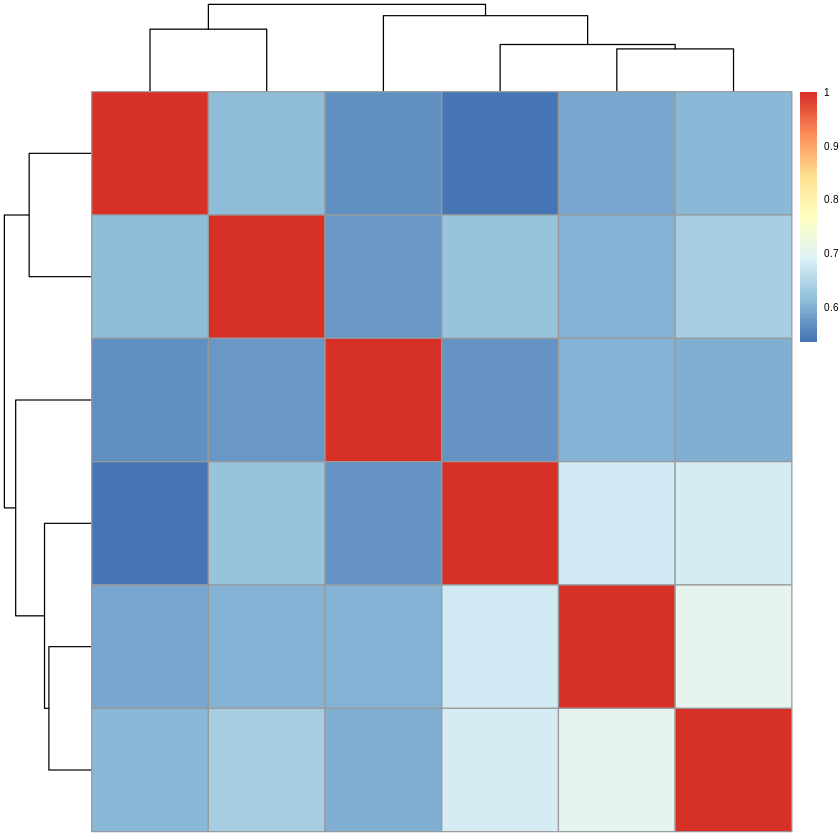

In [37]:
# dist_mat all values logFC_mat
dist_mat <- as.matrix(cor(logFC_mat))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/FigureGenesHeatmapAlllogFC.pdf"))

# dist_mat all values with logFC_mat normalizeQuantiles 
logFC_mat_NQ <- normalizeQuantiles(logFC_mat)
dist_mat <- as.matrix(cor(logFC_mat_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/FigureGenesHeatmapAlllogFC_NQ.pdf"))

# dist_mat all values with logFC_mat_gt_1.5 
dist_mat <- as.matrix(cor(logFC_gt_1.5))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/FigureGenesHeatmapAlllogFC_gt_1.5.pdf"))

# dist_mat all values with logFC_gt_1.5_mat normalizeQuantiles 
logFC_mat_gt_1.5_NQ <- normalizeQuantiles(logFC_gt_1.5)
dist_mat <- as.matrix(cor(logFC_mat_gt_1.5_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/FigureGenesHeatmapAlllogFC_gt_1.5NQ.pdf"))


In [38]:
rownames(dist_mat) <- colnames(logFC_mat_gt_1.5_NQ)
colnames(dist_mat) <- colnames(logFC_mat_gt_1.5_NQ)

message("Saving dist_mat object")
saveRDS(object = dist_mat, file = "../data/dist_mat.rds")
message("Done!")

Saving dist_mat object

Done!



## Generate panel 1c
A `heatplot` representing similarity in the fold-changes between male and female samples, 
with the values in the heatmap being the correlation between the vectors of fold changes of the tissues. </b>

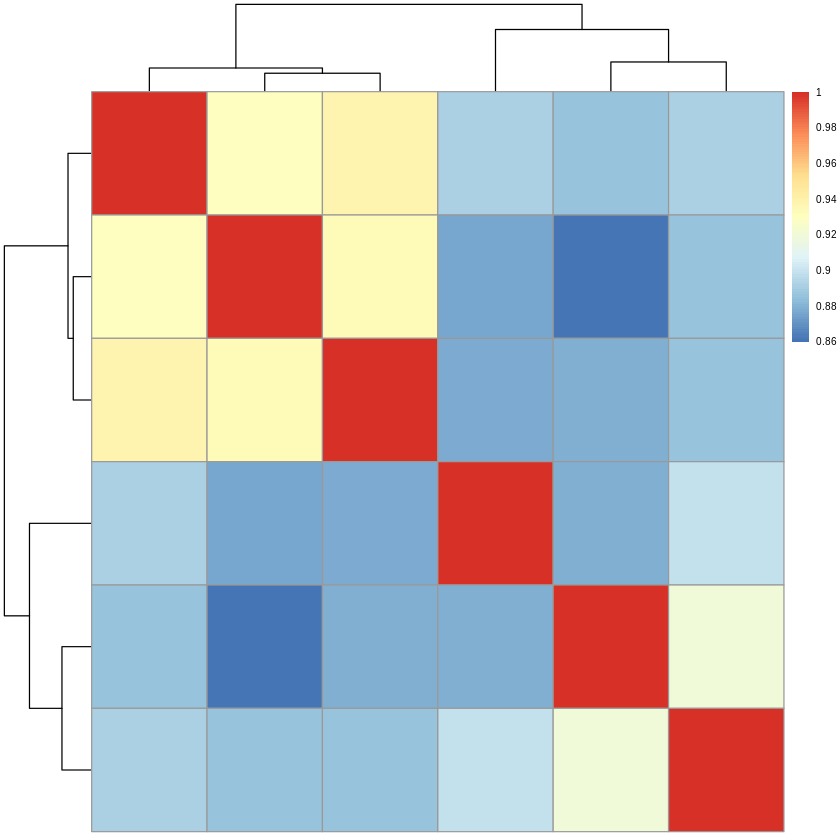

In [39]:
library(pheatmap)

pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/Figure1c.pdf"))

# Figure 1e - Number of sex-biased AS events per tissue type.

In [38]:
rm(totals)
totals <- read.table("../data/Totals_by_tissue.tsv", sep = "\t", header = T)
totals$Label <- totals$tissue
for (i in (1:length(totals[,"Tissue"]))) {
    id <- as.character(tissue_reduction[,"SMTSD"]) %in% as.character(totals[i,"Tissue"])
    totals[i,"Label"] <- tissue_reduction[id,"display_name"]
    message("\nmatch to display name\n",
        paste(totals[i,"Label"], collapse = " "))

}

colnames(totals) <- c("Tissue", "Total","Label")
totals_s <- totals %>% arrange(Total)
totals_s$Label <- factor(totals_s$Label, levels = totals_s$Label)
levels(totals_s$Label)



match to display name
Breast

match to display name
Nucleus accumbens

match to display name
Esophagus (mu)

match to display name
Aorta

match to display name
Fibroblasts

match to display name
Thyroid

match to display name
Pituitary

match to display name
Adipose (sc)

match to display name
Spleen

match to display name
Skeletal muscle

match to display name
Skin (exposed)

match to display name
Adrenal gland

match to display name
Adipose (v)

match to display name
Hippocampus

match to display name
EBV-lymphocytes

match to display name
Tibial artery

match to display name
Cerebellum

match to display name
Liver

match to display name
Esophagus (gej)

match to display name
Atrial appendage

match to display name
Esophagus (m)

match to display name
Pancreas

match to display name
Skin (not exposed)

match to display name
Cortex

match to display name
Spinal cord

match to display name
Lung

match to display name
Coronary artery

match to display name
Tibial nerve

match to displa

[1] "Frontal cortex"        "Sigmoid colon"         "Cerebellar hemisphere"
 [4] "Putamen"               "Whole blood"           "Transverse colon"     
 [7] "Small intestine"       "Caudate"               "Hypothalamus"         
[10] "Left ventricle"        "Stomach"               "Tibial nerve"         
[13] "Coronary artery"       "Spinal cord"           "Lung"                 
[16] "Cortex"                "Esophagus (m)"         "Pancreas"             
[19] "Skin (not exposed)"    "Atrial appendage"      "Esophagus (gej)"      
[22] "Cerebellum"            "Liver"                 "Tibial artery"        
[25] "EBV-lymphocytes"       "Hippocampus"           "Adipose (v)"          
[28] "Adrenal gland"         "Skin (exposed)"        "Skeletal muscle"      
[31] "Adipose (sc)"          "Spleen"                "Pituitary"            
[34] "Thyroid"               "Fibroblasts"           "Aorta"                
[37] "Esophagus (mu)"        "Nucleus accumbens"     "Breast"

### Write the Totals_by_tissue as Totals_by_tissue_annotated.txt

The file Totals_by_tissue.tsv was missing the `Label` which here has now been added.
write this out and release it for others to use.

In [39]:
write.table(totals_s, file="../data/Totals_by_tissue_annotated.txt", quote=FALSE, sep = "\t")

In [40]:
## Function to get a reverse log10 scale on the x axis
reverselog_trans <- function(base = exp(1)) {
  trans <- function(x) -log(x, base)
  inv <- function(x) base^(-x)
  trans_new(paste0("reverselog-", format(base)), trans, inv, 
            log_breaks(base = base), 
            domain = c(1e-100, Inf))
}


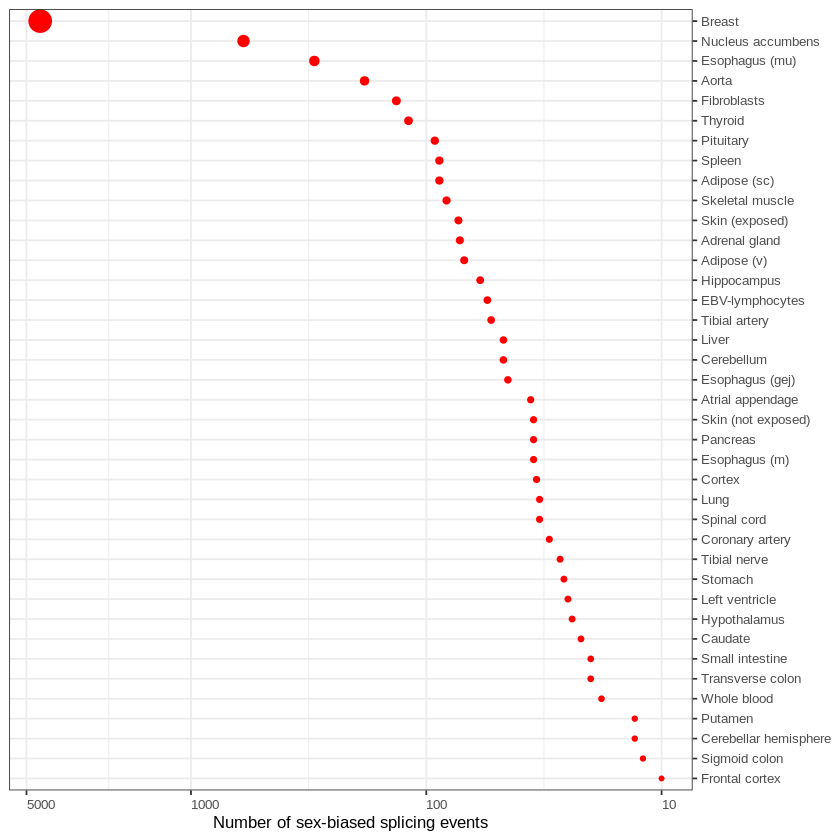

In [41]:
g<-ggplot(totals_s, aes(y = Label, x = Total, size = Total)) +
  geom_point(color = "red") +
  theme_bw() +
  scale_x_continuous(trans=reverselog_trans(), breaks=c(1,10,100,1000,5000,10000)) +#breaks=c(10000, 5000,1000,100,10,1)) +
  scale_y_discrete(position = "right") +
  theme(axis.text.x = element_text(size=8, angle = 0, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=8),
        axis.title.x = element_text(face="plain", colour="black", 
                                    size=10),
        axis.title.y = element_blank(),
        legend.title=element_blank(),
        legend.text = element_text(face="plain", colour="black", 
                                   size=8)) +
  xlab(paste("Number of sex-biased splicing events")) +
  ylab("Tissue") + 
  guides(size=FALSE)

g
ggsave("../pdf/Figure1d.pdf",g, height = 4.5, width = 4)

# 5 Metadata

For replicability and reproducibility purposes, we also print the following metadata:

## 5.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [42]:
figure_id   = "figure1"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



sha256sum,file
<chr>,<chr>
a9f73d24aedaa5f79bf5ff4d1f8809aa0ee3843972614b8a0b8cb767a366ccec,./liver_DGE.csv
8cdd37a8d59fad600f71afa6990ecd1f53fe98a42ea30004ba48dcaf671fb72d,./se_brain_hypothalamus_sjc_sex_universe.txt
e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855,./mxe_heart_left_ventricle_sex_as_events_gene_set.txt
bf4547760fb590dcb3e2fc283131757c1bdef03a546790a4323b66cd3d9d3021,./ri_esophagus_muscularis_sex_as_events_universe.txt
1d173f6d2b760e64965c458c6bd04a8cb0802b1f0b069cf5d90418aedebe72f7,./a5ss_thyroid_DGE_sex.csv
4eaab8f5ac7336054b4362a09c82f670317b842b9f5f352efcf49011b6a5d5c1,./a3ss_whole_blood_DGE_sex_as_events_refined.csv
9efbca6290f52a830d20b3b1e66cfba5178cab25fe5e7f0ab08b724eba48c6e6,./se_muscle_skeletal_sex_gene_set.txt
ce7cfd476dd881cf8997118dad34565685a9db56c24aa3896a840b054d5383e5,./a5ss_brain_spinal_cord_cervical_c_1_DGE_sjc_sex_refined.csv
784fc6ad657b4eddda9d28fb15cfcb35b5fb87bf315cddf0b9897a92d4c287a0,./a5ss_small_intestine_terminal_ileum_ijc_sex_universe.txt


## 5.2. Library metadata

In [43]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-06-03                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
magrittr,magrittr,1.5,1.5,/opt/conda/lib/R/library/magrittr,/opt/conda/lib/R/library/magrittr,TRUE,FALSE,2014-11-22,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
pheatmap,pheatmap,1.0.12,1.0.12,/opt/conda/lib/R/library/pheatmap,/opt/conda/lib/R/library/pheatmap,TRUE,FALSE,2019-01-04,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
scales,scales,1.1.0,1.1.0,/opt/conda/lib/R/library/scales,/opt/conda/lib/R/library/scales,TRUE,FALSE,2019-11-18,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
stringr,stringr,1.4.0,1.4.0,/opt/conda/lib/R/library/stringr,/opt/conda/lib/R/library/stringr,TRUE,FALSE,2019-02-10,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
viridis,viridis,0.5.1,0.5.1,/opt/conda/lib/R/library/viridis,/opt/conda/lib/R/library/viridis,TRUE,FALSE,2018-03-29,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
